<center>
<img src="logo.png" height="900"> 
</center>


# Свойства бутсрапа

В этом __необязательном__ задании мы изучим чуть ближе свойства бутстрапа.

In [1]:
import numpy as np
import pandas as pd

from scipy import stats as sts

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

plt.style.use('ggplot')
%matplotlib inline

Скопируем из лекции функцию для бустрапирования, которую мы написали. 

In [2]:
def get_bootstrap_sample(x, B_sample=1):
    N = x.size 
    sample = np.random.choice(x, size=(N, B_sample), replace=True)
    
    if B_sample == 1:
        sample = sample.T[0]
    return sample

# 0. Подготовка

Реализуем все три процедуры для строительства доверительного интервала, изученные нами на лекции. Начнём с перцентильного доверительного интервала.

In [4]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

def quantile_ci(x_boot, alpha=0.05):
    left = np.quantile(x_boot, alpha/2)
    right = np.quantile(x_boot, 1 - alpha/2)
    return left, right

In [5]:
# Убедимся, что функция реализована правильно
x = np.array([1,2,3,4])
l, r = quantile_ci(x)

assert np.abs(l - 1.07) < 1e-2
assert np.abs(r - 3.92) < 1e-2

Теперь обратный перцентильный доверительный интервал.

In [6]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

def reverse_quantile_ci(x_boot, theta_hat, alpha=0.05):
    left = 2 * theta_hat - np.quantile(x_boot, 1 - alpha/2)
    right = 2 * theta_hat - np.quantile(x_boot, alpha/2)
    return left, right

In [7]:
# Убедимся, что функция реализована правильно
l, r = reverse_quantile_ci(x, 2)

assert np.abs(l - 0.07) < 1e-2
assert np.abs(r - 2.92) < 1e-2

Остался только $t$-перцентильный доверительный интервал.

In [8]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

def t_ci(x_boot, std_boot, theta_hat, sd_hat, alpha=0.05):
    t_vals = (x_boot - theta_hat) / std_boot
    left_t = np.quantile(t_vals, 1 - alpha/2)
    right_t = np.quantile(t_vals, alpha/2)
    
    left = theta_hat - left_t * sd_hat
    right = theta_hat - right_t * sd_hat
    return left, right

In [9]:
# Убедимся, что функция реализована правильно
l, r = t_ci(x, x/10, 2, 2/10)

assert np.abs(l - 1.025) < 1e-2
assert np.abs(r - 3.85) < 1e-2

# 1. Бутстрап для симметричное распределения

Давайте сгенерируем $10^4$ раз выборку из симметричного распределения и построим для его среднего разные доверительные интервалы. Для каждого из них оценим, с какой вероятностью интервал действительно накрывает неизвестное среднее. Будем это делать на уровне значимости $5\%$.

In [10]:
n_int = 10**4      # число интервалов 
sample_size = 100  # размеры выборок

rv = sts.uniform(3,2)
theta_real = rv.mean() # настоящий параметр

# генерируем n_int выборок
X = rv.rvs((n_int, sample_size))
print('Математическое ожидание:', rv.mean())
X.shape

Математическое ожидание: 4.0


(10000, 100)

Напишем цикл для эксперимента: 

In [11]:
B = 10**3 # сколько делть бустрап-выборок

# счётчики для проверки как часто мы попали в интервал реальным параметром
i_q, i_rq, i_t = 0, 0, 0

for i in tqdm(range(n_int)):
    x = X[i] # взяли i-ую выборку 
    
    # оценки по выборке 
    theta_hat, sd_hat = np.mean(x), np.std(x)  
    
    # бутстрап-статистики 
    x_boot = get_bootstrap_sample(x, B_sample=B)
    std_boot = np.std(x_boot, axis=0)
    x_boot = np.mean(x_boot, axis=0)
    
    # quantile CI
    left1, right1 = quantile_ci(x_boot)
    i_q += (left1 < theta_real < right1)
    
    # reverse quantile CI
    left2, right2 = reverse_quantile_ci(x_boot, theta_hat)
    i_rq += (left2 < theta_real < right2)

    # t-percentile CI
    left3, right3 = t_ci(x_boot, std_boot, theta_hat, sd_hat)
    i_t += (left3 < theta_real < right3)
    
    # Напечатать интервалы после первой итерации
    if i == 0: 
        print('quantile:', left1, right1)
        print('quantile:', left2, right2)
        print('t-percentile:', left3, right3)

  1%|█▏                                                                           | 148/10000 [00:00<00:13, 738.22it/s]

quantile: 3.9315854223518807 4.162722347994884
quantile: 3.9308008677498405 4.161937793392844
t-percentile: 3.9268386447109975 4.16399797180723


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:12<00:00, 770.07it/s]


Исходный уровень доверия был $95\%$. Посмотрим как часто настоящее значение параметра оказывается внутри соотвествующего доверительного интервала. Если способ построения доверительного интервала хороший, полученная в ходе эксперимента частота, должна слабо отличаться от заявленного уровня доверия. 

In [12]:
i_q/n_int, i_rq/n_int, i_t/n_int

(np.float64(0.9452), np.float64(0.9429), np.float64(0.9525))

Видим, что доверительные интервалы оказываются похожими, а частота попадания истиного среднего в доверительный интервал близка к $0.95$. То есть уровень значимости близок к $5\%$. Если сделать больше итераций эксперимента (в районе $10^7$, мы получим числа совсем-совсем близкие к $0.95$. __Все три процедуры бутстрапирования хорошо себя показывают при работе с симметричным распределением.__

Действительно

# 2. Несимметричное распределение 

Сделаем то же самое для несимметричного случая. Сгенерируйте $10^4$ выборок размера $100$ из распределения хи-квадрат с одной степенью свободы. Постройте для одной из выборок гистограмму, убедитесь что наше распределение несимметрично относительно нуля и обладает длинным хвостом. 

(array([39., 10.,  8., 12.,  1.,  2.,  6.,  6.,  3.,  0.,  0.,  0.,  0.,
         1.,  2.,  2.,  2.,  0.,  0.,  1.,  0.,  2.,  0.,  1.,  0.,  1.,
         0.,  0.,  0.,  1.]),
 array([4.94466258e-05, 2.26739372e-01, 4.53429297e-01, 6.80119222e-01,
        9.06809148e-01, 1.13349907e+00, 1.36018900e+00, 1.58687892e+00,
        1.81356885e+00, 2.04025877e+00, 2.26694870e+00, 2.49363862e+00,
        2.72032855e+00, 2.94701848e+00, 3.17370840e+00, 3.40039833e+00,
        3.62708825e+00, 3.85377818e+00, 4.08046810e+00, 4.30715803e+00,
        4.53384795e+00, 4.76053788e+00, 4.98722780e+00, 5.21391773e+00,
        5.44060765e+00, 5.66729758e+00, 5.89398750e+00, 6.12067743e+00,
        6.34736735e+00, 6.57405728e+00, 6.80074721e+00]),
 <BarContainer object of 30 artists>)

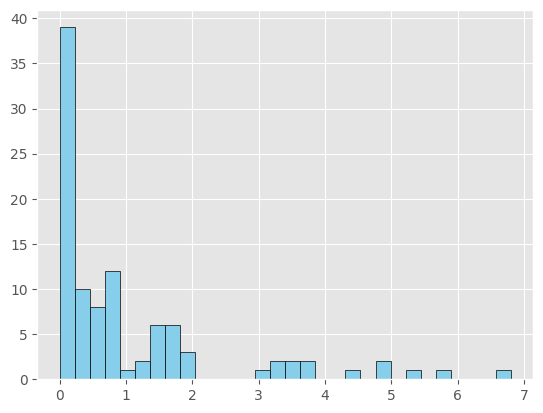

In [13]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

# your code here
from scipy import stats as sts
from tqdm import tqdm

rv_chi2 = sts.chi2(df=1)
theta_real_chi2 = rv_chi2.mean()
X_chi2 = rv_chi2.rvs((n_int, sample_size))
plt.hist(X_chi2[0], bins=30, color='skyblue', edgecolor='black')

Повторите тот же самый эксперимент, что и выше. 

In [14]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

B = 10**3 # сколько делть бустрап-выборок

# счётчики для проверки как часто мы попали в интервал реальным параметром
i_q, i_rq, i_t = 0, 0, 0

# your code here
i_q, i_rq, i_t = 0, 0, 0

for i in tqdm(range(n_int)):
    x = X_chi2[i]
    
    theta_hat = np.mean(x)
    sd_hat = np.std(x)
    
    x_boot = get_bootstrap_sample(x, B_sample=B)
    std_boot = np.std(x_boot, axis=0)
    x_boot_mean = np.mean(x_boot, axis=0)
    
    left1, right1 = quantile_ci(x_boot_mean)
    i_q += (left1 < theta_real_chi2 < right1)
    
    left2, right2 = reverse_quantile_ci(x_boot_mean, theta_hat)
    i_rq += (left2 < theta_real_chi2 < right2)
    
    left3, right3 = t_ci(x_boot_mean, std_boot, theta_hat, sd_hat)
    i_t += (left3 < theta_real_chi2 < right3)
    
    if i == 0:
        print(f'quantile CI: {left1:.3f}, {right1:.3f}')
        print(f'reverse quantile CI: {left2:.3f}, {right2:.3f}')
        print(f't-percentile CI: {left3:.3f}, {right3:.3f}')

print(f'Доля попаданий в quantile CI: {i_q / n_int:.3f}')
print(f'Доля попаданий в reverse quantile CI: {i_rq / n_int:.3f}')
print(f'Доля попаданий в t-percentile CI: {i_t / n_int:.3f}')

  2%|█▏                                                                           | 154/10000 [00:00<00:12, 767.44it/s]

quantile CI: 0.794, 1.346
reverse quantile CI: 0.751, 1.303
t-percentile CI: 0.799, 1.368


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:13<00:00, 763.84it/s]

Доля попаданий в quantile CI: 0.932
Доля попаданий в reverse quantile CI: 0.925
Доля попаданий в t-percentile CI: 0.947


Посмотрим на оценку поулчившихся частот.

In [15]:
i_q/n_int, i_rq/n_int, i_t/n_int

(np.float64(0.9319), np.float64(0.9253), np.float64(0.9468))

Близкой к 0.95 оказалась только последняя частота. Первые две довольно сильно от неё отличаются. Мы оказываемся в ситуации, когда перцентильный и обратный перцентильные интервалы приводят нас к смещённым оценкам границ доверительного интервала. При этом $t$-процентильный интервал показывает результаты на заявленном уровне доверия. 

Обратите внимание на границы, которые получились для разных доверительных интервалово. $t$-процентильный интервал уважительнее всего отнесся к тому, что исходное распределение скошено и выдал более далеко расположенные друг от друга критические значения. 

У них есть небольшая разница, но в целом, они все приближены к 0.95.

# 3. Бутсрап? А это точно? 

Мы сказали с вами, что бутстрап - это асимптотическая техника, которая при больших размерах выборки позволяет получать критические значения. 

Кроме размера выборки в бутстрапе фигурирует ещё и число испытаний, $B$. С ним связан интересный практический вопрос: как быстро бустрап сходится. Достаточно ли $10000$ испытаний? А достаточно ли $1000$ или $100$? 

В целом, чем больше тем лучше, но сейчас мы увидим, что даже для оценки CDF распределения верно, что $B_k$ сходится к $B_{\infty}$ (значение статистики при бесконечном количестве ресемплов) как $\frac{1}{\sqrt{n}}$.

Смотреть на то, как устроена эта сходимость, будем на треугольном распределении. Так обычно называют сумму двух равномерных случайных величин. 

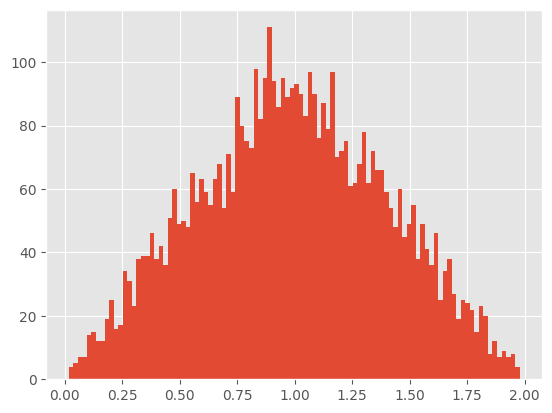

In [17]:
N = 5000 # размер изначальной выборки
X = np.random.uniform(0, 1, size=N) + np.random.uniform(0, 1, size=N)
plt.hist(X, bins=100);

Это распределение называют треугольным, так как его плотность распределения выглядит как треугольник. Вобьём его функцию распределения. Её можно найти в аналитическом виде. Она будет выглядеть вот так: 

In [18]:
def TrueTriangularDistrubition(x):
    if x < 0:
        return 0
    elif x < 1:
        return x**2 / 2
    elif x < 2:
        return 2*x - x**2 / 2 - 1
    else:
        return 1

Давайте сделаем $B=800$ бутсрап-выборок и для каждой из них построим эмпирическую функцию распределения. На этом же графике нарисуем исходную эмпирическую функцию распределения и теоретическую функцию распределения. 

In [19]:
N = 300 # размер изначальной выборки
B = 800 # размер бутстрепной выборки

x = np.random.uniform(0, 1, size=N) + np.random.uniform(0, 1, size=N)
Xb = get_bootstrap_sample(x, B_sample=B)
Xb.shape

(300, 800)

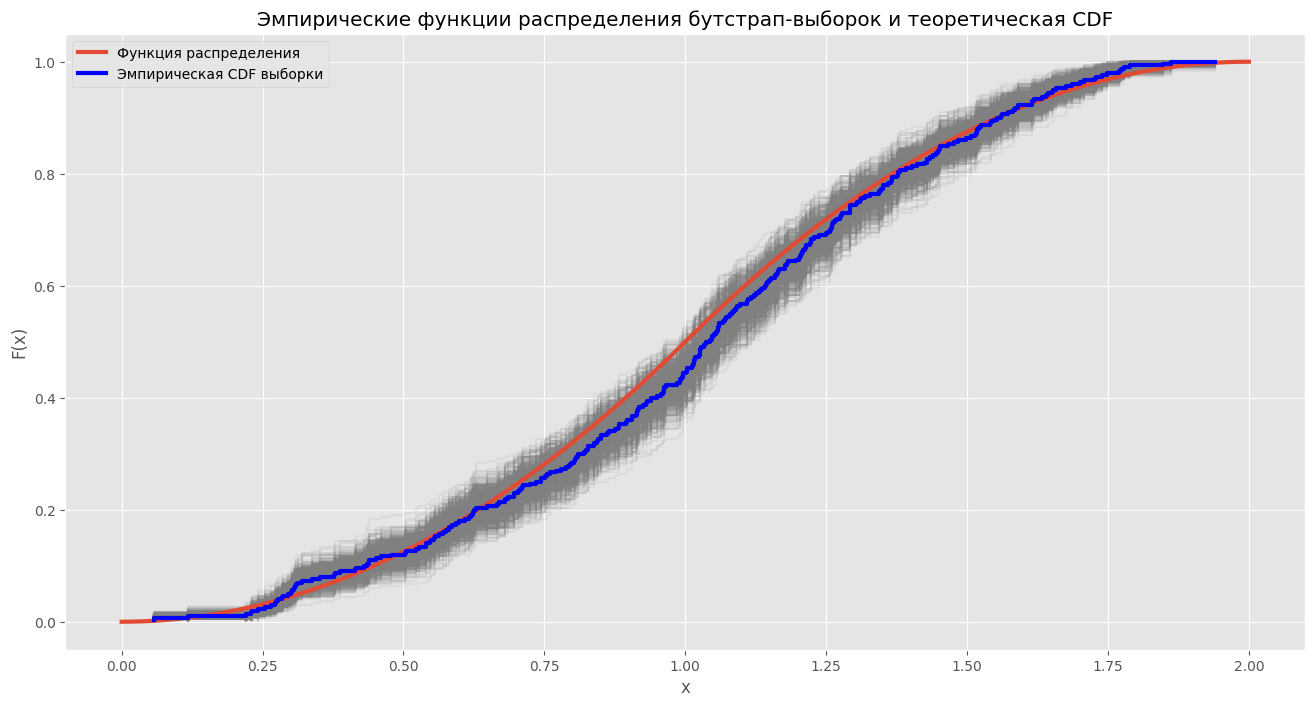

In [21]:
### ╰( ͡° ͜ʖ ͡° )つ▬▬ι═══════  bzzzzzzzzzz
# will the code be with you

from statsmodels.distributions.empirical_distribution import ECDF

plt.figure(figsize = (16, 8))

# CDF для каждого бутстрепной выборки
for i in range(B):
    ecdf_b = ECDF(Xb[:, i])
    plt.step(ecdf_b.x, ecdf_b.y, color='gray', alpha=0.1)
    
    
# Настоящая функция распределения
xs = np.linspace(0, 2, 100)
cdf = [TrueTriangularDistrubition(item) for item in xs]
plt.plot(xs, cdf, lw = 3, label='Функция распределения')

# эмпирическая функция распределения 
# your code here

ecdf_orig = ECDF(x)
plt.step(ecdf_orig.x, ecdf_orig.y, color='blue', lw=3, label='Эмпирическая CDF выборки')

plt.title('Эмпирические функции распределения бутстрап-выборок и теоретическая CDF')
plt.xlabel('x')
plt.ylabel('F(x)')
plt.legend()
plt.grid(True)
plt.show()

Мы не знаем теоретической функции распределения на практике. Мы используем эмпирическую функцию распределения, как бутсрап-аналог для реальности. Мы делаем вид, что у нас есть вся генеральная совокупность, а симуляции это наши независимые наблюдения из неё. 

По картинке видно, что все наши бустрап-выборки вытягиваются именно вдоль эмпирической функции, а не вдоль теоретической. __Мы действуем в предпосылке, что наша выборка хорошо описывает генеральную совокупность.__ Если это не так, мы будем получать неверные выводы.

Посмотрим на то, насколько хорошо, в среднем, бустраповыские эмпирические функции распределения, приближают наше исходное, теоретическое, распределение, при разных значениях $B$ (число бутсрап-выборок размера $N$).  

In [22]:
bins = np.linspace(0, 2, N)

# Настоящее распределение
true_distr = np.array([TrueTriangularDistrubition(item) for item in np.linspace(0, 2, N - 1)])

# диапазон количества испытаний для которых будем смотреть на зависимость
Bs = np.arange(1, 1000, 1)

means = []

for B in tqdm(Bs):
    # бутстрап выборки
    Xb = np.random.choice(x, (B, N), replace=True)
    
    cdfs = []
    for bootstrap_sample in Xb:
        
        # считаем насколько сильно CDF полученная бутстрапом отличается от настоящей
        # bins - те точки, где нам надо считать значения CDF, для удобства они всегда фиксированы
        # мы сначала находим гистограмму, а потом считаем по ней кумулятивную сумму, получается ECDF
        
        cdfs.append(
            true_distr - np.cumsum(np.histogram(bootstrap_sample, bins=bins)[0] / N)
        )
    # считаем среднее отличие по всем B функциям в каждой точке
    means.append(np.array(cdfs).mean(axis=0))

100%|████████████████████████████████████████████████████████████████████████████████| 999/999 [00:16<00:00, 62.41it/s]


Внутри вектора `means` записана средняя разница между бустрап-распределениями и теоретической функцией при разных $B$.

In [23]:
means = np.array(means)
means.shape

(999, 299)

Чем больше $B$, тем меньше должна быть эта разница. Тем не менее, объём исходной выборки, $N$, ограничен. То есть рано или поздно мы должны исчерпать повышение качества за счёт увелечиня $B$.

In [24]:
r = means.mean(axis=1) # усредним разницу по всем бинам
r.shape

(999,)

Если построить график средней ошибки, можно увидеть, что её дисперсия с ростом $B$ становится всё меньше. 

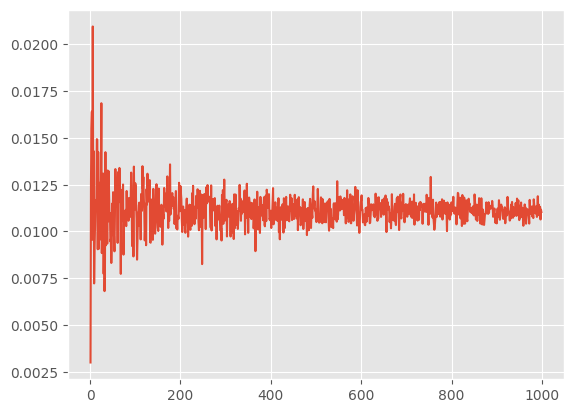

In [25]:
plt.plot(Bs[:len(r)], r);

Вопрос в том, как именно себя эта дисперсия ведёт. Давайте сгладим ёё. Для этого пройдёмся по полученному вектору ошибок скользящим окном. 

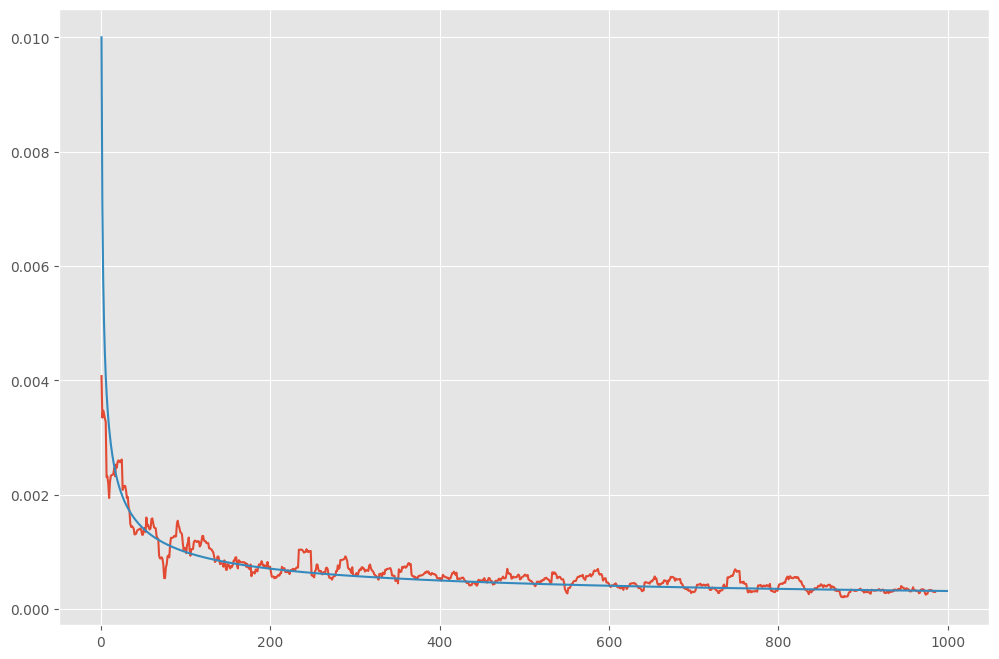

In [26]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

# считаем скользящее стандартное отклонение, чтобы получить более гладкий график
r = np.std(rolling_window(r, 15), -1)

plt.figure(figsize=(12, 8))
plt.plot(Bs[:len(r)], r)
plt.plot(Bs, 1e-2 / np.sqrt(Bs));

### Что мы видим? 

Мы видим, что ошибка постепенно уменьшается. Её стандартное отклонение падает. Причём оно падает как $\frac{1}{\sqrt{n}}$. Эта функция нанесена на картинку синим цветом. На практике для бутсрапа рекомендуется использовать размер бутстрапной выборки порядка $10000$ и больше.